In [373]:
import numpy as np
from time import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import pdspy.modeling as modeling
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.animation import FuncAnimation
import os
import pickle

import george
from george import kernels
from scipy.optimize import minimize

%matplotlib inline

In [356]:
param_names = ["T_star","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]

# get all model data
with open ('../grid_metadata/corefull.txt', 'rb') as fp:
    core= pickle.load(fp)
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)
    
dictionary=np.load("../grid_metadata/dictionary.npy")

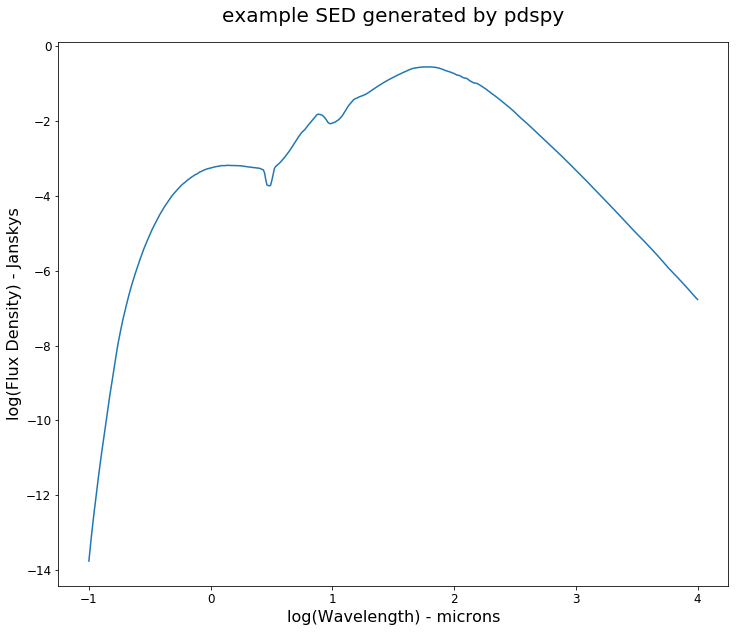

In [121]:
plt.figure(figsize=(12,10))
plt.plot(np.log10(xvals),cube[16])
plt.xlabel("log(Wavelength) - microns").set_fontsize(16)
plt.ylabel("log(Flux Density) - Janskys").set_fontsize(16)
plt.tick_params(labelsize=12)
plt.title("example SED generated by pdspy",pad=20).set_fontsize(20)
plt.show()

In [122]:
dictionary[16]

{'Tstar': 4218.751714594813,
 'logL_star': -0.8219494730537672,
 'logM_disk': -6.678976808923213,
 'logR_disk': 1.872527232441081,
 'h_0': 0.16330757481044356,
 'logR_in': -0.49760982277855625,
 'gamma': 0.6243294365074424,
 'beta': 1.083654218736818,
 'logM_env': -7.438784963711289,
 'logR_env': 2.881130921898599,
 'f_cav': 0.6154995415954266,
 'ksi': 0.7296769592070813,
 'loga_max': 4.555789974325001,
 'p': 4.279627681808531,
 'incl': 77.50844382956491,
 'filename': 'Tstar_4218.752_logLstar_-0.822_logMdisk_-6.679_logRdisk_1.873_h0_0.163_logRin_-0.498_gamma_0.624_beta_1.084_logMenv_-7.439_logRenv_2.1_fcav_0.615_ksi_0.730_logamax_4.556_p_4.280_incl_77.508.hdf5'}

In [366]:
param_names = ["T_star","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]

ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5],[-1.,2.5],[0.0,2.0],\
        [0.5,2.0],[-8.,-2.],[2.5,4.], [0.,1.], [0.5,1.5],[0.,5.],[2.5,4.5],[0.,90.]]
steps=[]
bases=[]
for i in range(len(ranges)):
    steps.append(np.linspace(ranges[i][0],ranges[i][1],11))
    bases.append(steps[i][5])

# get all model data
with open ('../grid_metadata/corefull.txt', 'rb') as fp:
    core= pickle.load(fp)[100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))[:,100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))[:,100:500]
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)[100:500]

# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# nan cutoff for means            
nancube[nancube<-20]=np.nan

In [367]:
# subtracting from the seds each sample mean
seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)

done in 0.106s


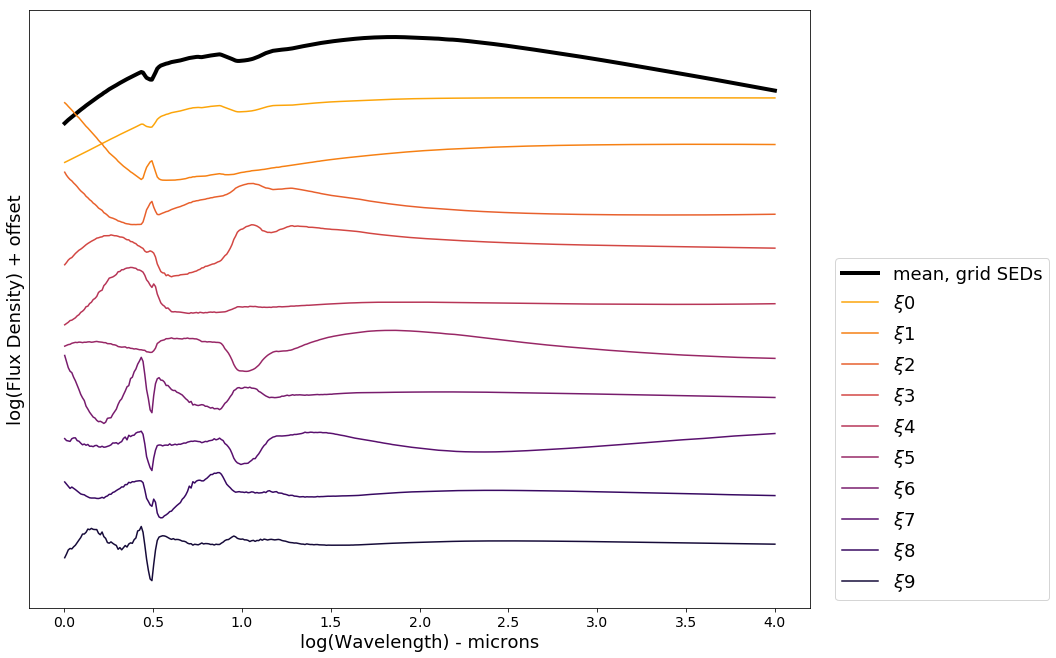

In [330]:
colors=plt.cm.inferno(np.linspace(0.1,0.8,10))
plt.figure(figsize=(14,11))
plt.plot(np.log10(xvals),np.mean(cube,axis=0),c='k',label="mean, grid SEDs",lw=4)
#plt.plot(np.log10(xvals),np.std(cube,axis=0),c='k',label="standard deviation, grid SEDs",linestyle="--")
for i in range(10):
    plt.plot(np.log10(xvals),(17+(15-2.5*i))*eigenseds[i]-(5*(i+1)),c=colors[-i-1],label=r'$\xi$'+(str(i)))
plt.xlabel("log(Wavelength) - microns").set_fontsize(18)
plt.ylabel("log(Flux Density) + offset").set_fontsize(18)
plt.tick_params(axis='x',labelsize=14)
plt.tick_params(axis='y',left=False,labelleft=False)
plt.legend(bbox_to_anchor=(1.02, 0.6),prop={'size':18})
plt.show()

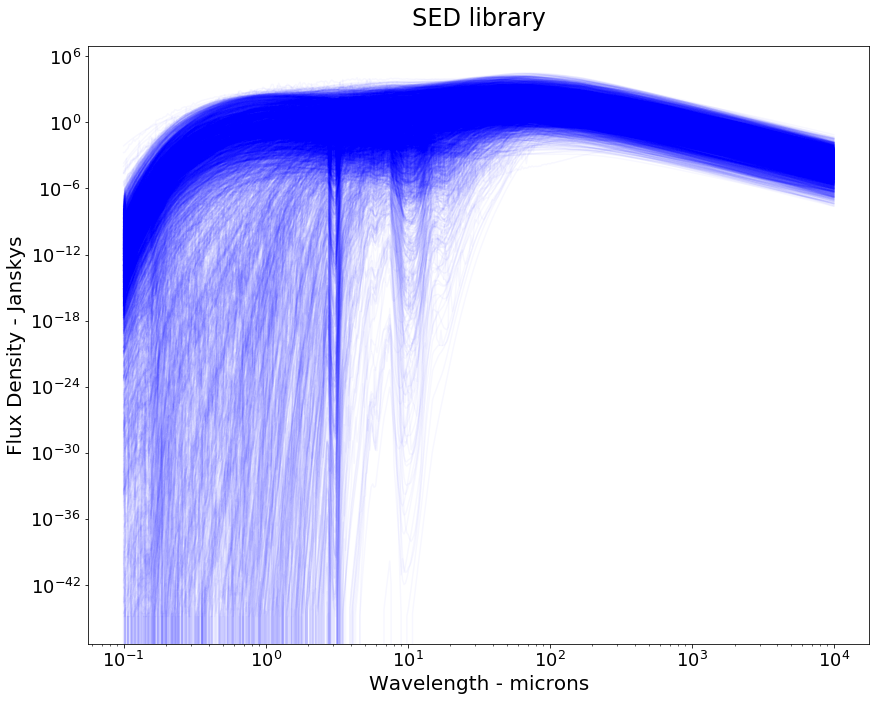

In [355]:
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)
    
plt.figure(figsize=(14,11))
for i in range(3850):
    plt.loglog(xvals,10**cube[i],c='b',alpha=0.03)
plt.xlabel("Wavelength - microns").set_fontsize(20)
plt.ylabel("Flux Density - Janskys").set_fontsize(20)
plt.title("SED library",fontsize=24,pad=20)
plt.tick_params(labelsize=18)
plt.show()

In [137]:
# get all model data
with open ('../grid_metadata/corefull.txt', 'rb') as fp:
    core= pickle.load(fp)
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube2 = np.array(pickle.load(fp))
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)

{'Tstar': 3318.3473905871806, 'logL_star': 0.6701565256060886, 'logM_disk': -7.030662855060957, 'logR_disk': 2.4494127440128395, 'h_0': 0.11090964441687287, 'logR_in': 1.9901760907363384, 'gamma': 0.2973489283532374, 'beta': 0.9213307772409279, 'logM_env': -2.571210784254651, 'logR_env': 2.7150692271270547, 'f_cav': 0.8011126009928704, 'ksi': 1.3253854814624968, 'loga_max': 4.187145571315856, 'p': 4.0843798325231075, 'incl': 27.758475665055528, 'filename': 'Tstar_3318.347_logLstar_0.670_logMdisk_-7.031_logRdisk_2.449_h0_0.111_logRin_1.990_gamma_0.297_beta_0.921_logMenv_-2.571_logRenv_2.715_fcav_0.801_ksi_1.325_logamax_4.187_p_4.084_incl_27.758.hdf5'}
{'Tstar': 4653.052320462147, 'logL_star': -0.38313598559255224, 'logM_disk': -3.9982899617848933, 'logR_disk': 1.477518043030409, 'h_0': 0.26805487811100126, 'logR_in': 1.0160353421339083, 'gamma': 0.7609600748069223, 'beta': 1.484156479744052, 'logM_env': -2.827779377052461, 'logR_env': 3.0432237200010728, 'f_cav': 0.17901442582888663, 'k

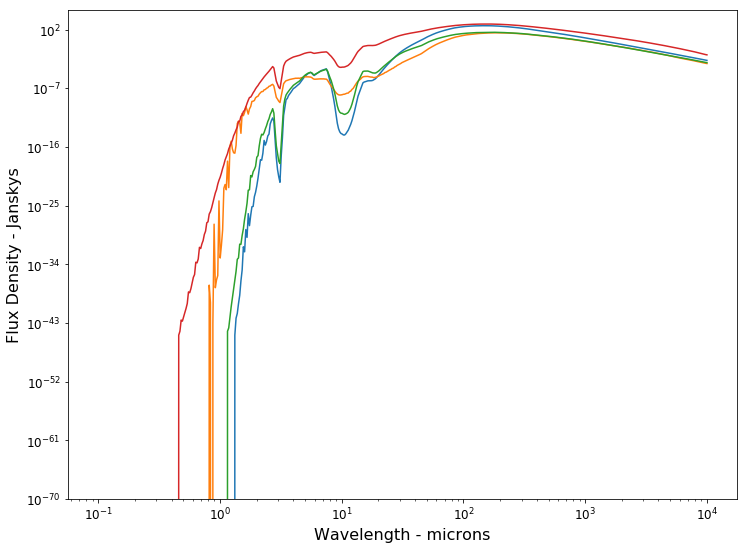

In [141]:
plt.figure(figsize=(12,9))
for i in (5,18,47,60):
    print(dictionary[i])
    plt.loglog(xvals,10**cube2[i])
    plt.ylim(1e-70,1e5)
    plt.ylabel("Flux Density - Janskys",fontsize=16)
    plt.xlabel("Wavelength - microns",fontsize=16)
    plt.tick_params(labelsize=12)
plt.show()

In [ ]:
inf=[]
for i in range(3850):
    if -np.inf in cube[i]:
        inf.append(i)

In [ ]:
dictionary[1]['logM_env']

In [ ]:
pars=[]
for j in range(len(param_names)):
    pars.append([])
    for i in range(len(inf)):
        pars[j].append(dictionary[i][param_names[4]])
        

In [ ]:
np.array(pars).shape

In [364]:
def sedcomp_anim(model,ncomp=40,nfeat=400):
    
    fig,ax= plt.subplots(figsize=(12,9))
    ax.plot(np.log10(xvals)[0:nfeat], cube[model][0:nfeat], c='black',label="pdspy SED")
    ax.tick_params(labelsize=16)
        
    coeffs=pca.transform(seds_msub[model].reshape(1,-1)) 
    reconst=[]
    for j in range(ncomp):
        reconst.append(np.dot(coeffs[0][0:j+1],eigenseds[0:j+1,0:nfeat]) +\
                       pca.mean_[0:nfeat]+np.nanmean(nancube[model]))
    
    line, = ax.plot(np.log10(xvals)[0:nfeat], reconst[0], c='b')
    
    ann_list=[]
    def animate(i):
        if not len(ann_list)==0:
            ax.texts.remove(ax.texts[0])
        
        line.set_ydata(reconst[int(i)])
        ax.set_xlabel("log(Wavelength) - microns",fontsize=16)
        if -np.inf in cube[model]:
            ax.set_ylim(-45,10)
        ann=ax.annotate("n = "+str(i),(1.53,-4),size=60)
        ann_list.append(ann)
        ax.set_ylabel("log(Flux Density) - Janskys",fontsize=16)
        ax.set_title("reconstructed SED against pdspy SED, number of components="+str(int(i)+1),fontsize=18,pad=20)
        return line,ax
    
    fs=np.ndarray.tolist(np.arange(0,ncomp))
    for i in range(2):
        fs.append(ncomp-1)
    anim=FuncAnimation(fig,animate,frames=fs,interval=1000)
    anim.save("../talk/"+str(model)+"_reconst.gif", dpi=72, writer="imagemagick")

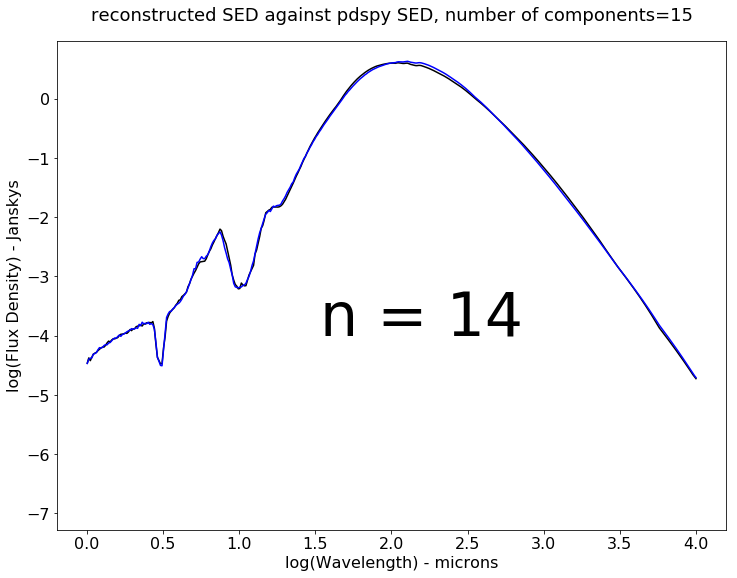

In [365]:
sedcomp_anim(35,ncomp=15)

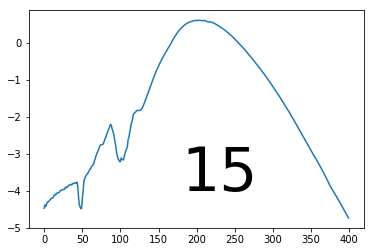

In [25]:
plt.plot(cube[35])
plt.annotate("15",(1.8,-4),size=60)
plt.show()

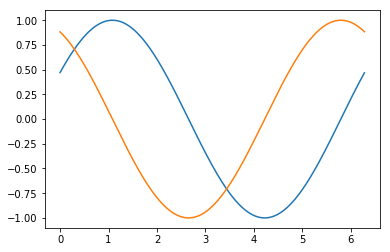

In [36]:
fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
x1 = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))
line1, =ax.plot(x1,np.cos(x1))


def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * len(x))
    line1.set_ydata([np.nan]*len(x1))
    return line, line1


def animate(i):
    line.set_ydata(np.sin(x + i / 100))  # update the data.
    line1.set_ydata(np.cos(x1+i/100))
    return line, line1


ani = FuncAnimation(
    fig, animate, init_func=init, interval=2, blit=True, save_count=50)

ani.save("../talk/test.gif", dpi=72, writer="imagemagick")



[-6.80260101 -6.80120695 -6.80385006 -6.80523966 -6.80354006 -6.80355968
 -6.80346315 -6.80332025 -6.80305671 -6.80351868 -6.80276916 -6.80293903
 -6.80315484 -6.80298017 -6.80295184]


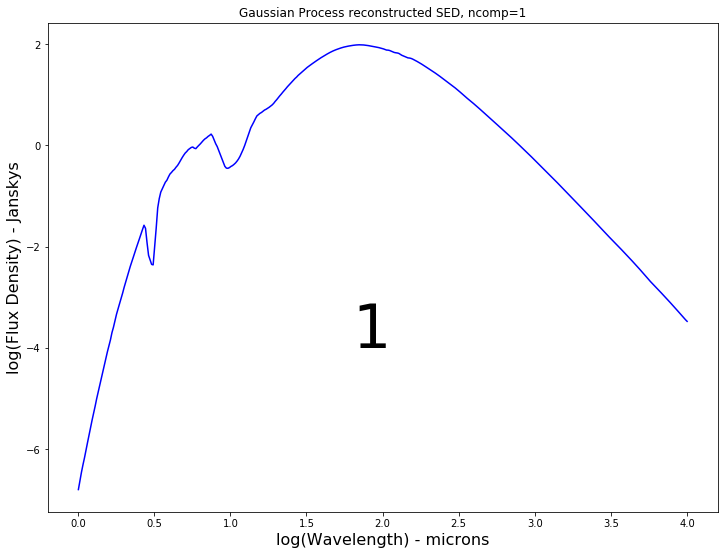

In [269]:
ncomp=15
nfeat=400
fig,ax= plt.subplots(figsize=(12,9))
coeffs=[ 0.00261589,  0.00859229, -0.02642946,  0.01958782, -0.01306668,\
        0.0094899 ,  0.00040921,  0.00391252,  0.00284936,  0.00271584,\
       -0.00346172,  0.0015432 , -0.0013069 ,  0.00112998,  0.00027086]
reconst=[]
for j in range(ncomp):
    reconst.append(np.dot(coeffs[0:j+1],eigenseds[0:j+1,0:nfeat]) +\
                   pca.mean_[0:nfeat])
print(np.array(reconst)[:,0])

line, = ax.plot(np.log10(xvals)[0:nfeat], reconst[0], c='b')

ann_list=[]
def animate(i):
    if not len(ann_list)==0:
        ax.texts.remove(ax.texts[0])
    line.set_ydata(reconst[int(i)])
    ax.set_xlabel("log(Wavelength) - microns",fontsize=16)
    ann=ax.annotate(str(i+1),(1.8,-4),size=60)
    ann_list.append(ann)
    ax.set_ylabel("log(Flux Density) - Janskys",fontsize=16)
    ax.set_title("Gaussian Process reconstructed SED, ncomp="+str(int(i)+1))
    return line,ax

fs=np.ndarray.tolist(np.arange(0,ncomp))
for i in range(4):
    fs.append(ncomp-1)
anim=FuncAnimation(fig,animate,frames=fs,interval=1000)
anim.save("../talk/test_gp_reconst.gif", dpi=72, writer="imagemagick")

In [368]:
# slices - read in filenames and logspace flux values
with open ('../grid_metadata/slicenames.txt', 'rb') as fp:
    slicenames = pickle.load(fp)
with open ('../grid_metadata/slicevals.txt', 'rb') as fp:
    slicevals = pickle.load(fp)[:,:,100:500]
with open ('../grid_metadata/slicevals.txt', 'rb') as fp:
    nanslicevals = pickle.load(fp)[:,:,100:500]

# fix -infs: powerlaw cutoff
for i in range(len(slicevals)):
    for j in range(len(slicevals[i])):
        if -np.inf in slicevals[i][j]:
            a = slicevals[i][j].tolist()
            a.reverse()
            ind = len(a)-a.index(-np.inf)
            x1 = xvals[ind]
            y1 = slicevals[i][j][ind]
            for m in range(ind):
                slicevals[i][j][m]=(100*(np.log10(xvals[m]/x1)))+y1
                
nanslicevals[nanslicevals<-20]=np.nan

slice_seds_msub = slicevals - np.nanmean(nanslicevals,axis=2)[:,:,np.newaxis]

In [371]:
fitdata=[]

for i in range(len(param_names)):
    fitdata.append([])
for i in range(len(param_names)):
    for j in range(11):
        modeldata=[]
        paramval=steps[i][j]
        coeffs=pca.transform(slice_seds_msub[i][j].reshape(1,-1))
        modeldata.append(paramval)
        for k in range(10):
            modeldata.append(coeffs[0][k])
        fitdata[i].append(modeldata)
paramvals=[]
weights=[]
for param in range(15):
    pl=[]
    wl=[]
    for model in range(11):
        pl.append(fitdata[param][model][0])
    paramvals.append(pl)
    
    for w in range(10):
        wsl=[]
        for model in range(11):
            wsl.append(fitdata[param][model][w+1])
        wl.append(wsl)
    weights.append(wl)
def load_pcwpar(param,weight):
    return np.array(paramvals[param]).reshape(-1,1), np.array(weights[param][weight])

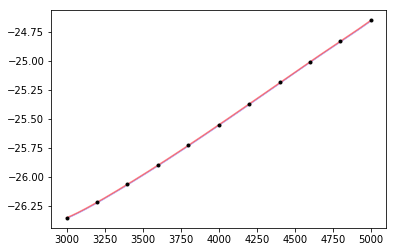

Initial ln-likelihood: -2822.72


In [374]:
X, y = load_pcwpar(0,0)

kernel = kernels.ExpSquaredKernel(900**2)* np.var(y)
gp = george.GP(kernel)
yerr=[j*0.00001 for j in y]
gp.compute(X,yerr)

x_pred = np.linspace(3000,5000,500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="b", alpha=0.2)
plt.plot(x_pred, pred, "r", lw=1.5, alpha=0.5)
plt.errorbar(X, y,yerr,fmt=".k", capsize=0)
plt.show()

print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

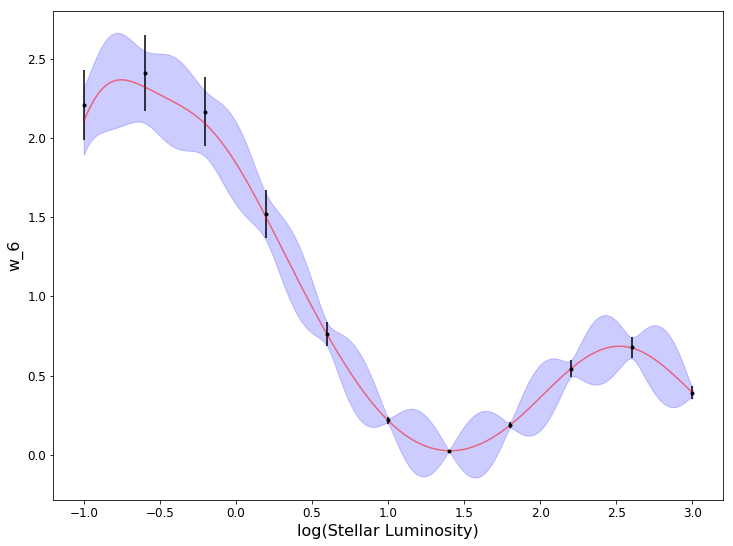

Initial ln-likelihood: -15.04


In [382]:
X, y = load_pcwpar(1,6)
yerr=[j*0.1 for j in y]

kernel = kernels.ExpSquaredKernel(.3**2) * np.var(y)

gp = george.GP(kernel)
gp.compute(X,yerr)

x_pred = np.linspace(-1,3,500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)
plt.figure(figsize=(12,9))
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="b", alpha=0.2)
plt.plot(x_pred, pred, "r", lw=1.5, alpha=0.5)
plt.errorbar(X, y, yerr,fmt=".k", capsize=0)
plt.xlabel("log(Stellar Luminosity)",fontsize=16)
plt.ylabel("w_6",fontsize=16)
plt.tick_params(labelsize=12)
plt.show()

print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

      fun: 0.4089847696845941
 hess_inv: array([[0.77305702, 0.2416093 ],
       [0.2416093 , 0.14045307]])
      jac: array([-1.26874411e-07,  1.67755161e-07])
  message: 'Optimization terminated successfully.'
     nfev: 14
      nit: 9
     njev: 14
   status: 0
  success: True
        x: array([0.71159268, 0.37881707])

Final ln-likelihood: -0.41


<ErrorbarContainer object of 3 artists>

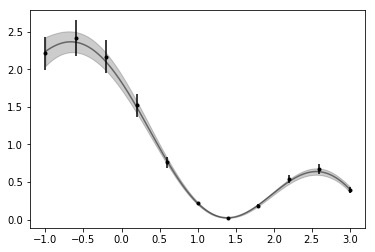

In [381]:

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(X, y, yerr, fmt=".k", capsize=0)